In [3]:
import pandas as pd
import seaborn as sns
import numpy as np
import csv
import matplotlib.pyplot as plt
from collections import Counter

In [4]:
from tueplots import figsizes, fontsizes

plt.rcParams.update(fontsizes.cvpr2024())  # Apply cvpr font sizes globally
plt.rcParams.update(figsizes.cvpr2024_half())  # Apply cvpr fig sizes globally (note: half-width is recommended for double-column formats)

# fontsizes.cvpr2024()  # Display font sizes
# figsizes.cvpr2024_half()  # Display fig sizes

In [5]:
results = pd.read_csv('2025-02-02_results_DECODED.csv')
results.head(4)

,Timestamp,Please choose the best model of this building. [Shape],Please choose the best model of this building. [Texture],Please choose the best model of this animal. [Shape],Please choose the best model of this animal. [Texture],Please choose the best model of this tree. [Shape],Please choose the best model of this tree. [Texture],Please choose the best model of the Statue of Liberty. [Shape],Please choose the best model of the Statue of Liberty. [Texture],Please choose the best model of this chair. [Shape],...,Please choose the best model of this microphone. [Shape],Please choose the best model of this microphone. [Texture],Please choose the best model of this angle figure. [Shape],Please choose the best model of this angle figure. [Texture],Please choose the best model of this rocking horse. [Shape],Please choose the best model of this rocking horse. [Texture],Please choose the best model of this figure. [Shape],Please choose the best model of this figure. [Texture],Please choose the best model of this ball. [Shape].1,Please choose the best model of this ball. [Texture].1
0,2025/01/19 8:08:11 pm CET,IM,LGM,Gen3Diffusion,Gen3Diffusion,LGM,TriplaneGaussian,Gen3Diffusion,Gen3Diffusion,TripoSR,...,TripoSR,TripoSR,TripoSR,TripoSR,TripoSR,TripoSR,TriplaneGaussian,TriplaneGaussian,IM,IM
1,2025/01/20 9:36:05 am CET,Gen3Diffusion,LGM,Gen3Diffusion,Gen3Diffusion,TripoSR,TripoSR,Gen3Diffusion,Gen3Diffusion,TripoSR,...,Gen3Diffusion,Gen3Diffusion,TripoSR,TripoSR,IM,Gen3Diffusion,LGM,LGM,IM,IM
2,2025/01/20 9:14:35 pm CET,LGM,LGM,Gen3Diffusion,TripoSR,LGM,TriplaneGaussian,Gen3Diffusion,Gen3Diffusion,TripoSR,...,Gen3Diffusion,Gen3Diffusion,TripoSR,TripoSR,IM,IM,TriplaneGaussian,TriplaneGaussian,IM,IM
3,2025/01/20 9:20:12 pm CET,IM,IM,Gen3Diffusion,TripoSR,LGM,TriplaneGaussian,LGM,Gen3Diffusion,LGM,...,Gen3Diffusion,Gen3Diffusion,TripoSR,IM,IM,Gen3Diffusion,TripoSR,TriplaneGaussian,TripoSR,TripoSR


In [6]:
results_ = pd.read_csv('2025-02-02_results_DECODED_adjusted.csv')

def extract_object_name(col):
    if '[Shape]' not in col:
        return None
    if 'of this' in col:
        obj = col.split('of this')[1].split('[')[0]
    elif 'of these' in col:
        obj = col.split('of these')[1].split('[')[0]
    else:
        obj = col.split('of the')[1].split('[')[0]

    return obj.strip(' .')

# Get unique objects and all model names
cols = results_.columns
objects = [extract_object_name(col) for col in cols if col is not None and '[Shape]' in col]
objects = list(filter(None, objects))

# Get all unique model names across all questions
all_models = pd.Index([])
for col in cols:
    if '[Shape]' in col or '[Texture]' in col:
        all_models = all_models.union(results_[col].unique())

# Initialize counts with complete index
counts_dict = {}
for obj in objects:
    shape_col = next(col for col in cols if obj in col and '[Shape]' in col)
    texture_col = next(col for col in cols if obj in col and '[Texture]' in col)
    
    # Get counts with consistent index
    shape_counts = results_[shape_col].value_counts().reindex(all_models).fillna(0)
    texture_counts = results_[texture_col].value_counts().reindex(all_models).fillna(0)
    
    # Store metrics
    counts_dict[(obj, 'Shape')] = shape_counts
    counts_dict[(obj, 'Texture')] = texture_counts
    counts_dict[(obj, 'Overall')] = shape_counts + texture_counts

# Create DataFrame and finalize
model_df = pd.DataFrame(counts_dict)
model_df = model_df.fillna(0).astype(int)

# Add overall metrics
model_df['Overall', 'Shape'] = model_df[[col for col in model_df.columns if 'Shape' in col[1]]].sum(axis=1)
model_df['Overall', 'Texture'] = model_df[[col for col in model_df.columns if 'Texture' in col[1]]].sum(axis=1)
model_df['Overall', 'Overall'] = model_df[[col for col in model_df.columns if 'Overall' in col[1]]].sum(axis=1)

model_df = model_df.sort_values(('Overall', 'Overall'), ascending=False)

model_df

building                 animal                  tree  \
                    Shape Texture Overall  Shape Texture Overall Shape   
TripoSR                 0       0       0      4      11      15     1   
IM                      8       5      13      1       2       3     1   
Gen3Diffusion           2       0       2      9       3      12     1   
TriplaneGaussian        0       0       0      6       4      10     4   
LGM                    10      15      25      0       0       0    13   

                                 Statue of Liberty  ... rocking horse figure  \
                 Texture Overall             Shape  ...       Overall  Shape   
TripoSR                3       4                 1  ...             7      5   
IM                     4       5                 1  ...            18      6   
Gen3Diffusion          0       1                11  ...            15      0   
TriplaneGaussian       7      11                 4  ...             0      8   
LGM                    6      19                 3  ...             0      1   

                                 soccer ball                 Overall          \
                 Texture Overall       Shape Texture Overall   Shape Texture   
TripoSR                7      12           5       6      11     332     317   
IM                     8      14          14      12      26     254     245   
Gen3Diffusion          0       0           1       2       3     103     123   
TriplaneGaussian       5      13           0       0       0      88      95   
LGM                    0       1           0       0       0      83      80   

                          
                 Overall  
TripoSR              649  
IM                   499  
Gen3Diffusion        226  
TriplaneGaussian     183  
LGM                  163  

[5 rows x 132 columns]

In [7]:
# Get shape and texture columns
shape_cols = [col for col in cols if '[Shape]' in col]
texture_cols = [col for col in cols if '[Texture]' in col]

# Initialize empty DataFrames for each category
subject_responses = {}

# Process texture questions
texture_responses = pd.DataFrame()
for model in all_models:
    texture_responses[model] = results_[texture_cols].apply(lambda row: (row == model).sum(), axis=1)

# Process shape questions
shape_responses = pd.DataFrame()
for model in all_models:
    shape_responses[model] = results_[shape_cols].apply(lambda row: (row == model).sum(), axis=1)

# Combine into multi-index DataFrame
response_df = pd.concat({
    'Texture': texture_responses,
    'Shape': shape_responses,
    'Overall': texture_responses + shape_responses
}, axis=1)

# Sort by total responses
response_df = response_df.sort_values(('Overall', all_models[0]), ascending=False)
"""
# Display results
print("\nNumber of responses per model for each subject:")
response_df
"""

'\n# Display results\nprint("\nNumber of responses per model for each subject:")\nresponse_df\n'

In [8]:
print(response_df.head(5))

         Texture                                          Shape          \
   Gen3Diffusion  IM LGM TriplaneGaussian TripoSR Gen3Diffusion  IM LGM   
15            13   8   7                8       7             6  13   8   
11             8  11   8                8       8             8  11   8   
9              9   5   2                6      21             6  10   2   
0              7  10   1                7      18             6  12   1   
17             7   7   9                6      14             6   9   6   

                                  Overall                                   
   TriplaneGaussian TripoSR Gen3Diffusion  IM LGM TriplaneGaussian TripoSR  
15                3      13            19  21  15               11      20  
11                8       8            16  22  16               16      16  
9                 4      21            15  15   4               10      42  
0                 5      19            13  22   2               12      37  
17          

Percentage of participants selecting the same model for shape and texture: 75.00%


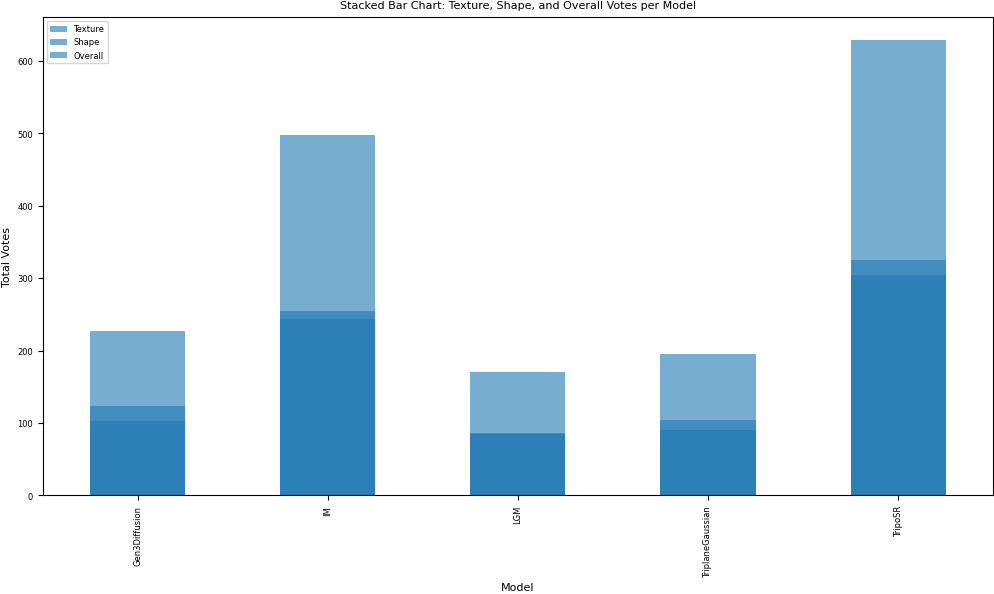

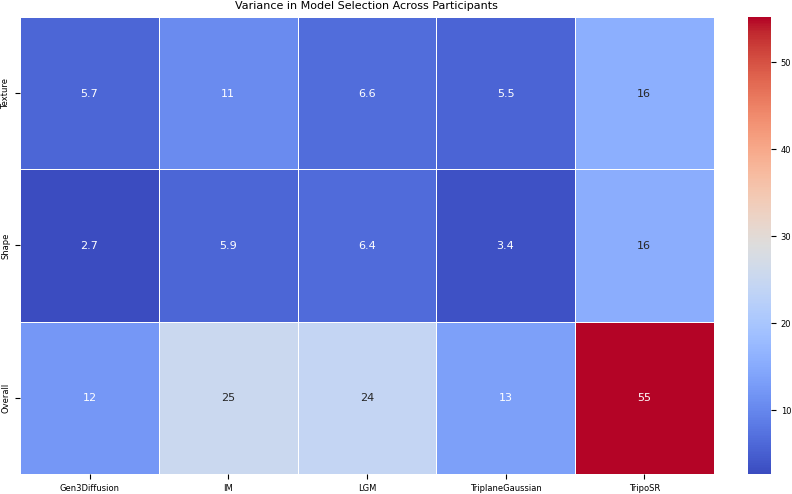

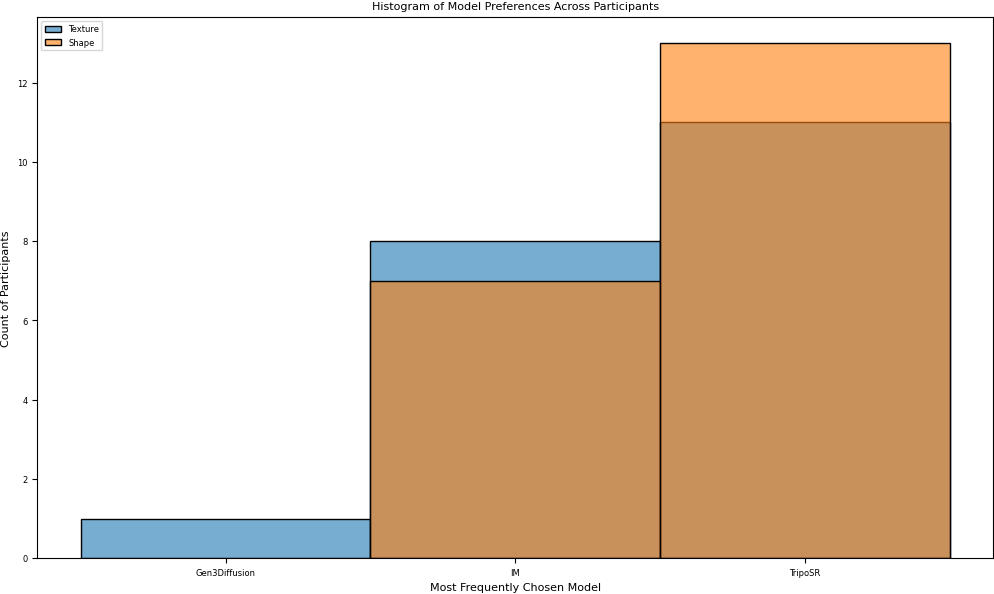

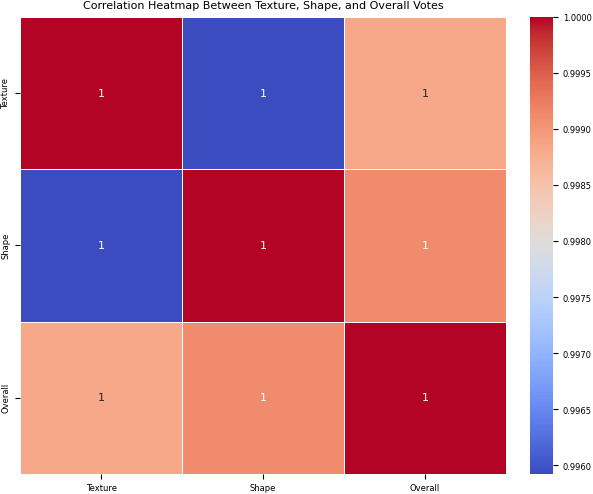

In [9]:
# Assuming `response_df` is already computed from your process

# Extract shape, texture, and overall responses
df_texture = response_df["Texture"]
df_shape = response_df["Shape"]
df_overall = response_df["Overall"]

# Check how often participants picked the same model for texture and shape
same_choice_ratio = (df_texture.idxmax(axis=1) == df_shape.idxmax(axis=1)).mean()
print(f"Percentage of participants selecting the same model for shape and texture: {same_choice_ratio * 100:.2f}%")

# ====== Plot 1: Stacked Bar Chart for Model Selection ======
plt.figure(figsize=(10, 6))
df_texture.sum().plot(kind='bar', alpha=0.6, label="Texture")
df_shape.sum().plot(kind='bar', alpha=0.6, label="Shape")
df_overall.sum().plot(kind='bar', alpha=0.6, label="Overall")
plt.xlabel("Model")
plt.ylabel("Total Votes")
plt.title("Stacked Bar Chart: Texture, Shape, and Overall Votes per Model")
plt.legend()
plt.show()

# ====== Plot 2: Variance in Participant Responses ======
df_variance = pd.DataFrame({
    "Texture": df_texture.var(axis=0),
    "Shape": df_shape.var(axis=0),
    "Overall": df_overall.var(axis=0)
})

plt.figure(figsize=(8, 5))
sns.heatmap(df_variance.T, annot=True, cmap="coolwarm", linewidths=0.5)
plt.title("Variance in Model Selection Across Participants")
plt.show()

# ====== Plot 3: Histogram of Most Chosen Model per Participant ======
plt.figure(figsize=(10, 6))
sns.histplot(df_texture.idxmax(axis=1), label="Texture", alpha=0.6)
sns.histplot(df_shape.idxmax(axis=1), label="Shape", alpha=0.6)
plt.xlabel("Most Frequently Chosen Model")
plt.ylabel("Count of Participants")
plt.title("Histogram of Model Preferences Across Participants")
plt.legend()
plt.show()

# ====== Plot 4: Correlation Heatmap Between Texture, Shape, and Overall ======
df_corr = pd.concat([df_texture.sum(), df_shape.sum(), df_overall.sum()], axis=1)
df_corr.columns = ["Texture", "Shape", "Overall"]
plt.figure(figsize=(6, 5))
sns.heatmap(df_corr.corr(), annot=True, cmap="coolwarm", linewidths=0.5)
plt.title("Correlation Heatmap Between Texture, Shape, and Overall Votes")
plt.show()


In [10]:
# This threw me a runtime error when I changed the figsizes globally ~Leon

"""# Create figure with subplots
plt.style.use('seaborn-v0_8')
fig = plt.figure(figsize=(20, 15))

# 1. Total Votes Comparison
plt.subplot(2, 2, 1)
model_df[('Overall', 'Shape')].plot(kind='bar', color='skyblue', alpha=0.7)
model_df[('Overall', 'Texture')].plot(kind='bar', color='lightgreen', alpha=0.7)
plt.title('Total Votes by Category', fontsize=12)
plt.legend(['Shape', 'Texture'])
plt.xticks(rotation=45)

# 2. Heatmap of performance across objects
plt.subplot(2, 2, 2)
object_overall = pd.DataFrame()
for obj in objects:
    object_overall[obj] = model_df[(obj, 'Overall')]
sns.heatmap(object_overall, annot=True, fmt='d', cmap='YlOrRd')
plt.title('Model Performance Across Objects', fontsize=12)
plt.xticks(rotation=45)

# 3. Box plot of vote distribution
plt.subplot(2, 2, 3)
vote_data = []
for obj in objects:
    vote_data.append(model_df[(obj, 'Overall')])
plt.boxplot(vote_data, labels=objects)
plt.title('Vote Distribution by Object', fontsize=12)
plt.xticks(rotation=45)

# 4. Radar Chart for top 3 models
plt.subplot(2, 2, 4, projection='polar')
top_3_models = model_df.head(3).index
categories = objects
num_vars = len(categories)
angles = [n / float(num_vars) * 2 * np.pi for n in range(num_vars)]
angles += angles[:1]

for model in top_3_models:
    values = [model_df.loc[model, (obj, 'Overall')] for obj in objects]
    values += values[:1]
    plt.plot(angles, values, linewidth=1, label=model)
    plt.fill(angles, values, alpha=0.1)

plt.title('Top 3 Models Performance', fontsize=12)
plt.legend(loc='upper right', bbox_to_anchor=(0.1, 0.1))

plt.tight_layout()
plt.show()

# Print statistical summary
print("\nStatistical Summary:")
print("\nRankings by Overall Score:")
print(model_df[('Overall', 'Overall')].sort_values(ascending=False))

print("\nVariance across objects:")
print(object_overall.var().sort_values(ascending=False))
"""

'# Create figure with subplots\nplt.style.use(\'seaborn-v0_8\')\nfig = plt.figure(figsize=(20, 15))\n\n# 1. Total Votes Comparison\nplt.subplot(2, 2, 1)\nmodel_df[(\'Overall\', \'Shape\')].plot(kind=\'bar\', color=\'skyblue\', alpha=0.7)\nmodel_df[(\'Overall\', \'Texture\')].plot(kind=\'bar\', color=\'lightgreen\', alpha=0.7)\nplt.title(\'Total Votes by Category\', fontsize=12)\nplt.legend([\'Shape\', \'Texture\'])\nplt.xticks(rotation=45)\n\n# 2. Heatmap of performance across objects\nplt.subplot(2, 2, 2)\nobject_overall = pd.DataFrame()\nfor obj in objects:\n    object_overall[obj] = model_df[(obj, \'Overall\')]\nsns.heatmap(object_overall, annot=True, fmt=\'d\', cmap=\'YlOrRd\')\nplt.title(\'Model Performance Across Objects\', fontsize=12)\nplt.xticks(rotation=45)\n\n# 3. Box plot of vote distribution\nplt.subplot(2, 2, 3)\nvote_data = []\nfor obj in objects:\n    vote_data.append(model_df[(obj, \'Overall\')])\nplt.boxplot(vote_data, labels=objects)\nplt.title(\'Vote Distribution by

# Question 1: Ranking

In [11]:
input_filename = "2025-02-02_results_DECODED.csv"
output_filename = "model_ranking.csv"

# Fixed list of possible models (adjust if necessary)
models = ["IM", "LGM", "Gen3Diffusion", "TriplaneGaussian", "TripoSR"]

# Dictionary to hold counts per pair.
# Structure: { pair_id (str): { "Shape": Counter(), "Texture": Counter() } }
ranking = {}

# Open the input CSV and read header and data.
with open(input_filename, newline="") as f:
    reader = csv.reader(f)
    header = next(reader)
    
    # The first column is Timestamp; the remaining columns form pairs.
    num_pairs = (len(header) - 1) // 2
    # Initialize dictionary for each pair with a two-digit ID.
    for i in range(num_pairs):
        pair_id = f"{i+1:02d}"
        ranking[pair_id] = {"Shape": Counter(), "Texture": Counter()}
    
    # Process each row.
    for row in reader:
        # For each pair, get the Shape answer and Texture answer.
        for i in range(num_pairs):
            pair_id = f"{i+1:02d}"
            shape_index = 1 + 2 * i
            texture_index = shape_index + 1
            # Update the counter if the indices are valid.
            if shape_index < len(row):
                shape_ans = row[shape_index].strip()
                ranking[pair_id]["Shape"][shape_ans] += 1
            if texture_index < len(row):
                texture_ans = row[texture_index].strip()
                ranking[pair_id]["Texture"][texture_ans] += 1

# Prepare the output rows.
# The output will have these headers:
output_header = ["PairID", "Part"] + models + ["TopModel"]
output_rows = []

# For each pair (sorted by pair id), create one row for Shape and one row for Texture.
for pair_id in sorted(ranking.keys()):
    for part in ["Shape", "Texture"]:
        counter = ranking[pair_id][part]
        row_dict = {"PairID": pair_id, "Part": part}
        # Add a column for each model count.
        for model in models:
            row_dict[model] = counter.get(model, 0)
        # Determine the top model (if there are ties, max() returns one arbitrarily).
        if counter:
            top_model = max(counter.items(), key=lambda x: x[1])[0]
        else:
            top_model = ""
        row_dict["TopModel"] = top_model
        output_rows.append(row_dict)

# Create aggregated global counters for Shape and Texture.
global_shape = Counter()
global_texture = Counter()
for pair_data in ranking.values():
    global_shape += pair_data["Shape"]
    global_texture += pair_data["Texture"]

# Add two final rows: one aggregating all Shape counts, one for Texture.
for part, global_counter in zip(["Shape", "Texture"], [global_shape, global_texture]):
    row_dict = {"PairID": "ALL", "Part": part}
    for model in models:
        row_dict[model] = global_counter.get(model, 0)
    if global_counter:
        top_model = max(global_counter.items(), key=lambda x: x[1])[0]
    else:
        top_model = ""
    row_dict["TopModel"] = top_model
    output_rows.append(row_dict)

"""
# Write the output CSV with all fields quoted.
with open(output_filename, "w", newline="") as f:
    writer = csv.DictWriter(f, fieldnames=output_header, quoting=csv.QUOTE_ALL)
    writer.writeheader()
    for row in output_rows:
        writer.writerow(row)

print(f"Ranking output written to '{output_filename}'.")
"""

for i in range(5):
    print(output_rows[i])
print("...")
print(output_rows[-2])
print(output_rows[-1])

{'PairID': '01', 'Part': 'Shape', 'IM': 8, 'LGM': 10, 'Gen3Diffusion': 2, 'TriplaneGaussian': 0, 'TripoSR': 0, 'TopModel': 'LGM'}
{'PairID': '01', 'Part': 'Texture', 'IM': 5, 'LGM': 15, 'Gen3Diffusion': 0, 'TriplaneGaussian': 0, 'TripoSR': 0, 'TopModel': 'LGM'}
{'PairID': '02', 'Part': 'Shape', 'IM': 1, 'LGM': 0, 'Gen3Diffusion': 9, 'TriplaneGaussian': 6, 'TripoSR': 4, 'TopModel': 'Gen3Diffusion'}
{'PairID': '02', 'Part': 'Texture', 'IM': 2, 'LGM': 0, 'Gen3Diffusion': 3, 'TriplaneGaussian': 4, 'TripoSR': 11, 'TopModel': 'TripoSR'}
{'PairID': '03', 'Part': 'Shape', 'IM': 1, 'LGM': 13, 'Gen3Diffusion': 1, 'TriplaneGaussian': 4, 'TripoSR': 1, 'TopModel': 'LGM'}
...
{'PairID': 'ALL', 'Part': 'Shape', 'IM': 255, 'LGM': 86, 'Gen3Diffusion': 103, 'TriplaneGaussian': 91, 'TripoSR': 325, 'TopModel': 'TripoSR'}
{'PairID': 'ALL', 'Part': 'Texture', 'IM': 243, 'LGM': 85, 'Gen3Diffusion': 124, 'TriplaneGaussian': 104, 'TripoSR': 304, 'TopModel': 'TripoSR'}


## 1.1 Shape and Texture

/tmp/ipykernel_8728/2745810023.py:46: UserWarning: The figure layout has changed to tight
  fig.tight_layout()


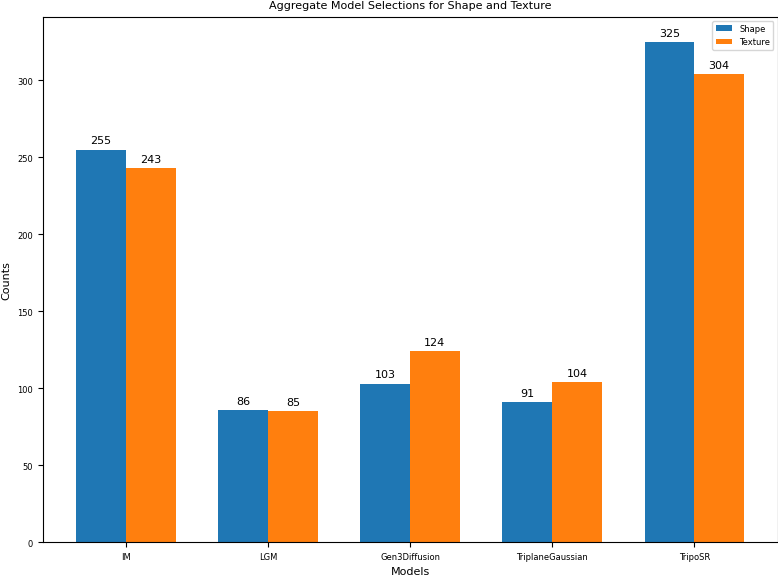

In [12]:
# Assume these variables are defined from your notebook code:
# - models: list of model names, e.g. ["IM", "LGM", "Gen3Diffusion", "TriplaneGaussian", "TripoSR"]
# - output_rows: list of dictionaries, where output_rows[-2] is the global Shape row and output_rows[-1] is the global Texture row

# Extract the aggregate rows
aggregate_shape = output_rows[-2]   # For Shape: {"PairID": "ALL", "Part": "Shape", "IM": count, ... }
aggregate_texture = output_rows[-1] # For Texture: {"PairID": "ALL", "Part": "Texture", "IM": count, ... }

# Get counts for each model in the order of models
shape_counts = [aggregate_shape[model] for model in models]
texture_counts = [aggregate_texture[model] for model in models]

# Set up the positions and width for the bars
x = np.arange(len(models))
width = 0.35  # width of the bars

# Create the plot
fig, ax = plt.subplots(figsize=(8, 6))

# Create grouped bars
rects_shape = ax.bar(x - width/2, shape_counts, width, label='Shape')
rects_texture = ax.bar(x + width/2, texture_counts, width, label='Texture')

# Add labels, title, and custom x-axis tick labels
ax.set_xlabel('Models')
ax.set_ylabel('Counts')
ax.set_title('Aggregate Model Selections for Shape and Texture')
ax.set_xticks(x)
ax.set_xticklabels(models)
ax.legend()

# Function to add labels above bars for clarity
def autolabel(rects):
    """Attach a text label above each bar displaying its height."""
    for rect in rects:
        height = rect.get_height()
        ax.annotate(f'{height}',
                    xy=(rect.get_x() + rect.get_width()/2, height),
                    xytext=(0, 3),  # Offset label above the bar
                    textcoords="offset points",
                    ha='center', va='bottom')

autolabel(rects_shape)
autolabel(rects_texture)

fig.tight_layout()
plt.show()


In [13]:
# ! UTIL

# Assume that 'ranking' and 'models' are already defined as before.
# Get sorted PairIDs.
pair_ids = sorted(ranking.keys())

# Build a DataFrame for Shape counts.
data_shape = []
for pid in pair_ids:
    data_shape.append([ranking[pid]["Shape"].get(model, 0) for model in models])
df_shape = pd.DataFrame(data_shape, index=pair_ids, columns=models)

# Build a DataFrame for Texture counts.
data_texture = []
for pid in pair_ids:
    data_texture.append([ranking[pid]["Texture"].get(model, 0) for model in models])
df_texture = pd.DataFrame(data_texture, index=pair_ids, columns=models)

# Transpose the DataFrames so that models are rows and pair_ids are columns.
df_shape_transposed = df_shape.T
df_texture_transposed = df_texture.T


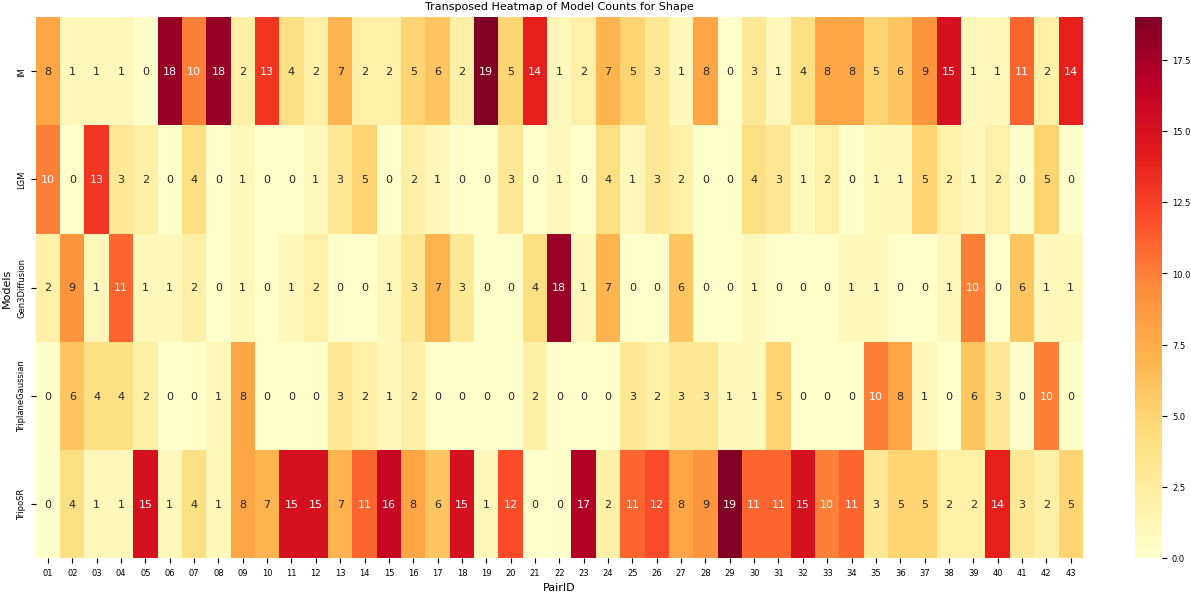

In [14]:
# Plot the transposed heatmap for Shape using a warm-only colour scheme.
plt.figure(figsize=(12, 6))
sns.heatmap(df_shape_transposed, annot=True, fmt="d", cmap="YlOrRd")
plt.title("Transposed Heatmap of Model Counts for Shape")
plt.xlabel("PairID")
plt.ylabel("Models")
plt.show()

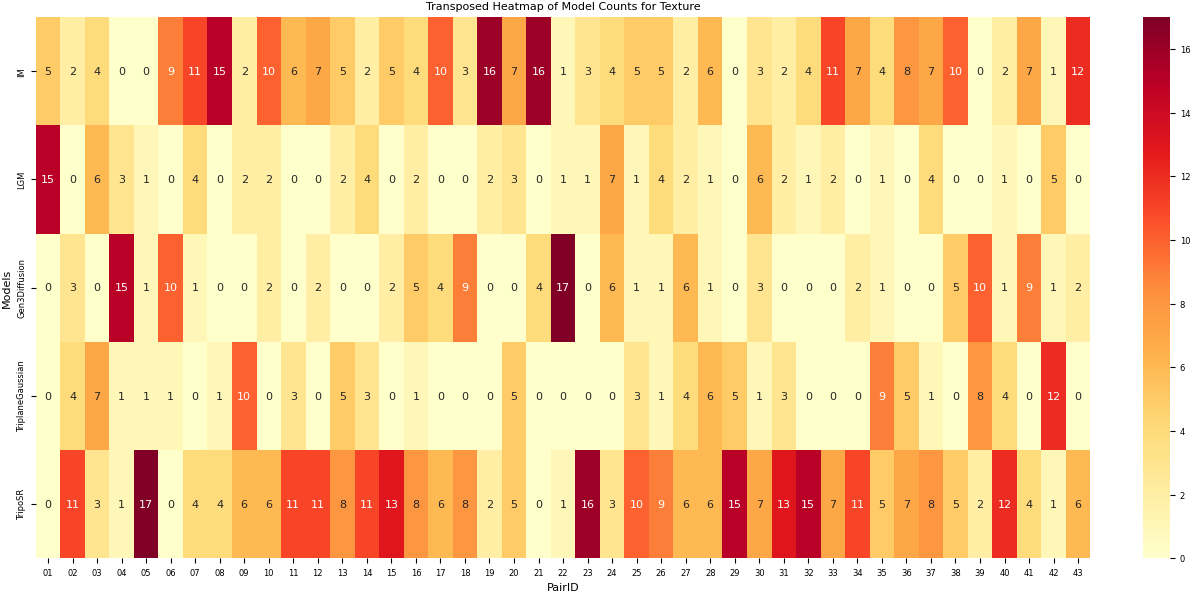

In [15]:
# Plot the transposed heatmap for Texture using a warm-only colour scheme.
plt.figure(figsize=(12, 6))
sns.heatmap(df_texture_transposed, annot=True, fmt="d", cmap="YlOrRd")
plt.title("Transposed Heatmap of Model Counts for Texture")
plt.xlabel("PairID")
plt.ylabel("Models")
plt.show()

## 1.2 Correlation

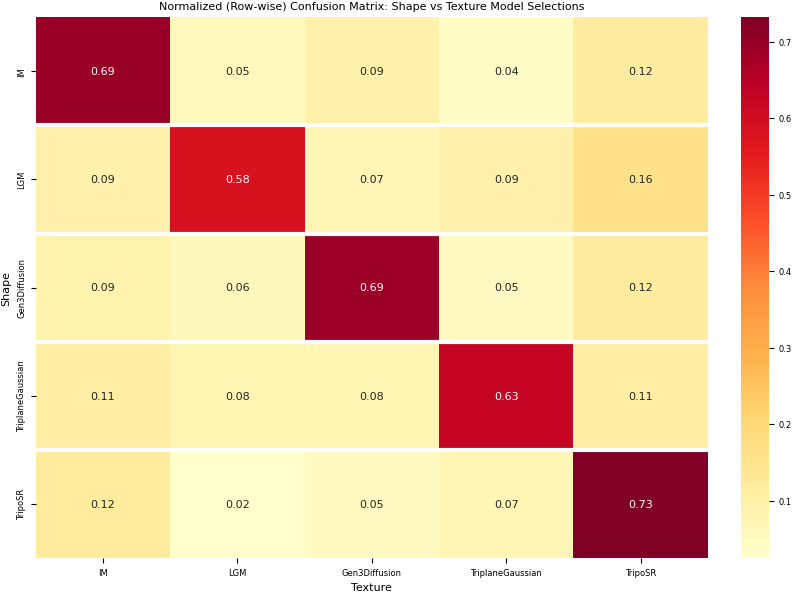

In [16]:
# Fixed list of possible models.
models = ["IM", "LGM", "Gen3Diffusion", "TriplaneGaussian", "TripoSR"]

input_filename = "2025-02-02_results_DECODED.csv"

# Accumulate counts for each (shape, texture) pair.
confusion_counts = Counter()

with open(input_filename, newline="") as f:
    reader = csv.reader(f)
    header = next(reader)
    # First column is Timestamp; the remaining columns form pairs.
    num_pairs = (len(header) - 1) // 2

    for row in reader:
        for i in range(num_pairs):
            shape_index = 1 + 2 * i
            texture_index = shape_index + 1
            if shape_index < len(row) and texture_index < len(row):
                shape_ans = row[shape_index].strip()
                texture_ans = row[texture_index].strip()
                confusion_counts[(shape_ans, texture_ans)] += 1

# Create a matrix with rows = shape selections and columns = texture selections.
matrix = np.zeros((len(models), len(models)), dtype=int)
for i, shape in enumerate(models):
    for j, texture in enumerate(models):
        matrix[i, j] = confusion_counts[(shape, texture)]

df_confusion = pd.DataFrame(matrix, index=models, columns=models)

# Normalize row-wise: each row is divided by its sum so that it sums to 1.
df_norm = df_confusion.div(df_confusion.sum(axis=1), axis=0)

plt.figure(figsize=(8, 6))
# Disable built-in grid by setting linewidths=0.
ax = sns.heatmap(df_norm, annot=True, fmt=".2f", cmap="YlOrRd", linewidths=0)
plt.title("Normalized (Row-wise) Confusion Matrix: Shape vs Texture Model Selections")
plt.xlabel("Texture")
plt.ylabel("Shape")

# Manually add white horizontal lines between rows.
# These lines provide extra white spacing only between rows.
for i in range(1, df_norm.shape[0]):
    ax.axhline(i, color='white', linewidth=3)

plt.show()


# Question 2: Variance in Votes

/tmp/ipykernel_8728/2827331963.py:42: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


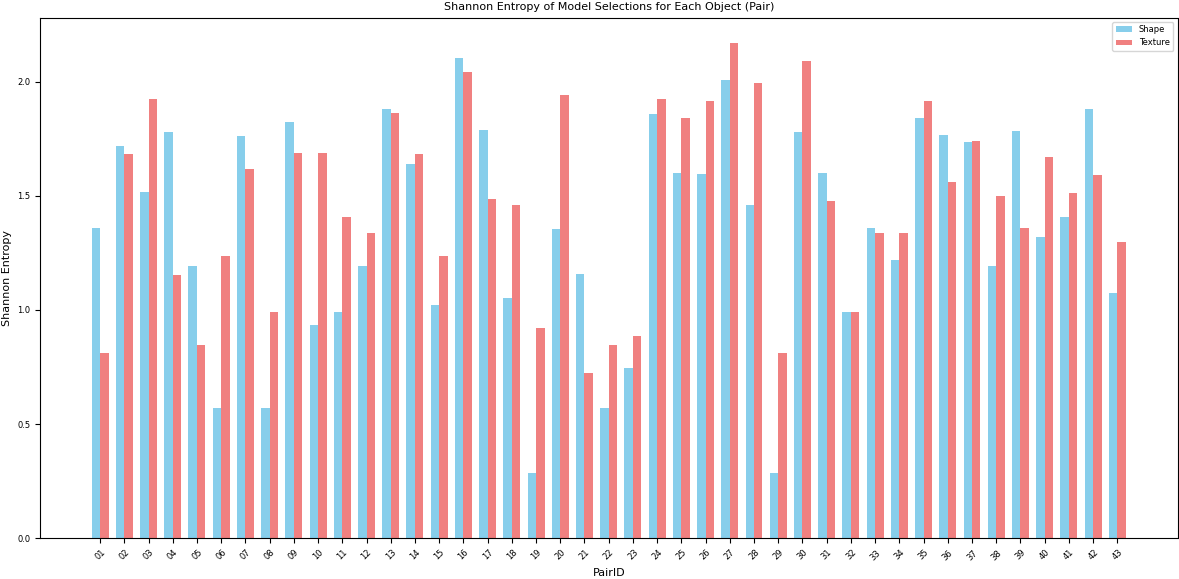

In [17]:
def shannon_entropy(counter):
    """Compute the Shannon entropy for a Counter/dictionary of counts.
    Entropy is defined as: -Σ(p_i * log₂ p_i) over all items.
    """
    total = sum(counter.values())
    if total == 0:
        return 0
    entropy = 0
    for count in counter.values():
        if count > 0:
            p = count / total
            entropy -= p * np.log2(p)
    return entropy

# Compute entropy for each PairID and for each part.
entropy_shape = {}
entropy_texture = {}
for pair_id, parts in ranking.items():
    entropy_shape[pair_id] = shannon_entropy(parts["Shape"])
    entropy_texture[pair_id] = shannon_entropy(parts["Texture"])

# Sort the PairIDs to have a consistent x-axis.
pair_ids_sorted = sorted(ranking.keys())

# Create arrays of entropy values.
entropy_shape_values = np.array([entropy_shape[p] for p in pair_ids_sorted])
entropy_texture_values = np.array([entropy_texture[p] for p in pair_ids_sorted])

# Create a grouped bar chart.
x = np.arange(len(pair_ids_sorted))
width = 0.35  # width of each bar

plt.figure(figsize=(12, 6))
plt.bar(x - width/2, entropy_shape_values, width, label='Shape', color='skyblue')
plt.bar(x + width/2, entropy_texture_values, width, label='Texture', color='lightcoral')

plt.xlabel('PairID')
plt.ylabel('Shannon Entropy')
plt.title('Shannon Entropy of Model Selections for Each Object (Pair)')
plt.xticks(x, pair_ids_sorted, rotation=45)
plt.legend()
plt.tight_layout()
plt.show()


In [18]:
# ! UTIL

def shannon_entropy(counter):
    """Compute the Shannon entropy for a Counter/dictionary of counts.
    Entropy is defined as: -Σ(p_i * log₂ p_i) over all items.
    """
    total = sum(counter.values())
    if total == 0:
        return 0
    entropy = 0
    for count in counter.values():
        if count > 0:
            p = count / total
            entropy -= p * np.log2(p)
    return entropy

# Compute entropy for each PairID and for each part.
entropy_shape = {}
entropy_texture = {}
for pair_id, parts in ranking.items():
    entropy_shape[pair_id] = shannon_entropy(parts["Shape"])
    entropy_texture[pair_id] = shannon_entropy(parts["Texture"])

# Sort the pair IDs in ascending order based on entropy.
pair_ids_shape_sorted = sorted(entropy_shape, key=lambda pid: entropy_shape[pid])
entropy_shape_values_sorted = [entropy_shape[pid] for pid in pair_ids_shape_sorted]

pair_ids_texture_sorted = sorted(entropy_texture, key=lambda pid: entropy_texture[pid])
entropy_texture_values_sorted = [entropy_texture[pid] for pid in pair_ids_texture_sorted]

/tmp/ipykernel_8728/3102268127.py:9: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


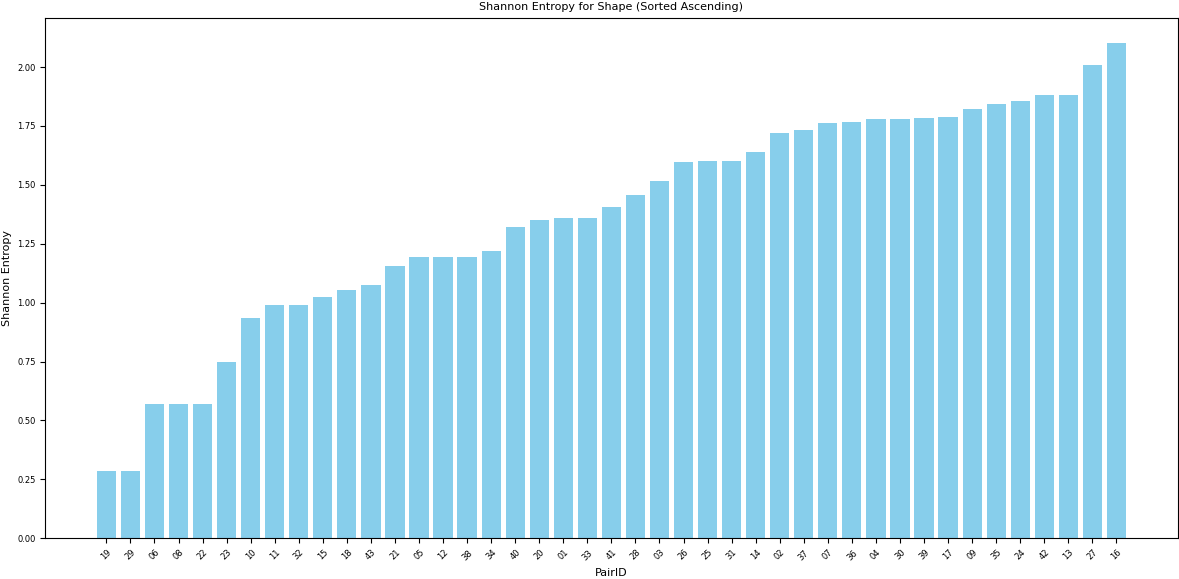

In [19]:
# Plot for Shape
plt.figure(figsize=(12, 6))
x_shape = np.arange(len(pair_ids_shape_sorted))
plt.bar(x_shape, entropy_shape_values_sorted, color='skyblue')
plt.xlabel('PairID')
plt.ylabel('Shannon Entropy')
plt.title('Shannon Entropy for Shape (Sorted Ascending)')
plt.xticks(x_shape, pair_ids_shape_sorted, rotation=45)
plt.tight_layout()
plt.show()

/tmp/ipykernel_8728/237601558.py:9: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


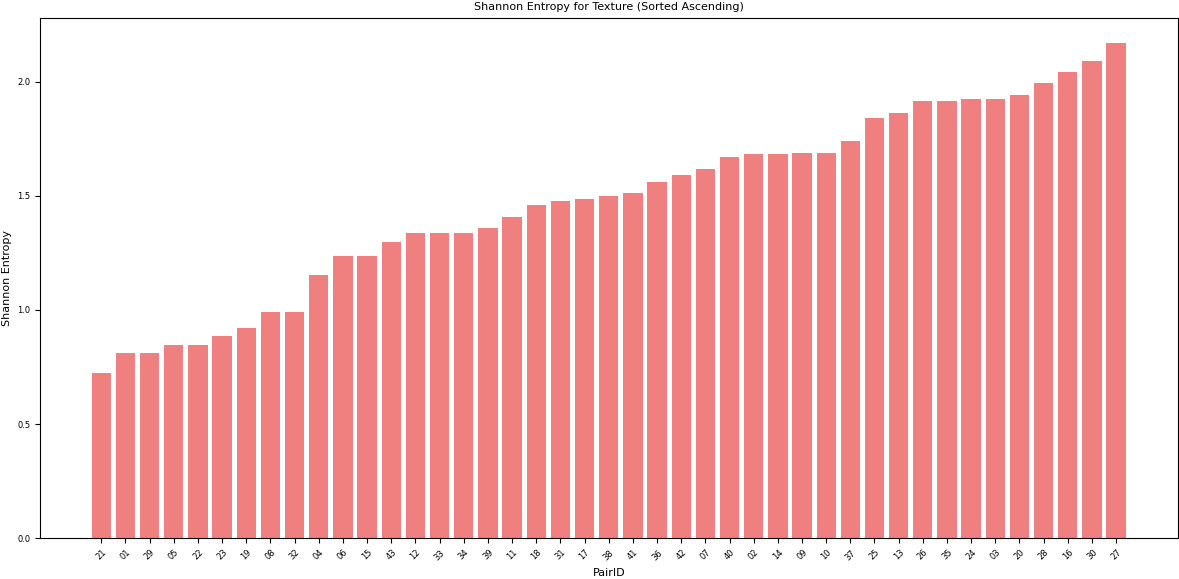

In [20]:
# Plot for Texture
plt.figure(figsize=(12, 6))
x_texture = np.arange(len(pair_ids_texture_sorted))
plt.bar(x_texture, entropy_texture_values_sorted, color='lightcoral')
plt.xlabel('PairID')
plt.ylabel('Shannon Entropy')
plt.title('Shannon Entropy for Texture (Sorted Ascending)')
plt.xticks(x_texture, pair_ids_texture_sorted, rotation=45)
plt.tight_layout()
plt.show()

# Question 3: Individual Preference

In [21]:
# Compute per-user ranking with paired rows (one for Shape, one for Texture)
user_ranking_rows = []

# Iterate over each user (the index of response_df holds user ids)
for user_id, row in response_df.iterrows():
    for part in ['Shape', 'Texture']:
        # Get the count series for this part; index are model names
        counts = row[part]
        row_dict = {'UserID': user_id, 'Part': part}
        # For each model (using all_models as our complete index), add its count
        for model in all_models:
            row_dict[model] = counts.get(model, 0)
        # Determine the top model (if there is a tie, idxmax returns one arbitrarily)
        if counts.sum() > 0:
            top_model = counts.idxmax()
        else:
            top_model = ""
        row_dict["TopModel"] = top_model
        user_ranking_rows.append(row_dict)

# Create a DataFrame from the computed rows
user_ranking_df = pd.DataFrame(user_ranking_rows)

# Optionally, sort the DataFrame by UserID and then by Part (if needed)
user_ranking_df = user_ranking_df.sort_values(['UserID', 'Part'])

# Display the first few rows of the per-user ranking DataFrame
print(user_ranking_df.head(10))


    UserID     Part  Gen3Diffusion  IM  LGM  TriplaneGaussian  TripoSR  \
6        0    Shape              6  12    1                 5       19   
7        0  Texture              7  10    1                 7       18   
16       1    Shape              6  13    6                 2       16   
17       1  Texture              7  11    7                 2       16   
30       2    Shape              4  17    4                 3       15   
31       2  Texture              5  11    4                 4       19   
10       3    Shape              6  15    3                 2       17   
11       3  Texture              7  15    2                 6       13   
20       4    Shape              4  15    2                 8       14   
21       4  Texture              7  14    3                 5       14   

   TopModel  
6   TripoSR  
7   TripoSR  
16  TripoSR  
17  TripoSR  
30       IM  
31  TripoSR  
10  TripoSR  
11       IM  
20       IM  
21       IM  


In [22]:
user_ranking_df

,UserID,Part,Gen3Diffusion,IM,LGM,TriplaneGaussian,TripoSR,TopModel
6,0,Shape,6,12,1,5,19,TripoSR
7,0,Texture,7,10,1,7,18,TripoSR
16,1,Shape,6,13,6,2,16,TripoSR
17,1,Texture,7,11,7,2,16,TripoSR
30,2,Shape,4,17,4,3,15,IM
31,2,Texture,5,11,4,4,19,TripoSR
10,3,Shape,6,15,3,2,17,TripoSR
11,3,Texture,7,15,2,6,13,IM
20,4,Shape,4,15,2,8,14,IM
21,4,Texture,7,14,3,5,14,IM


/tmp/ipykernel_8728/1793555792.py:32: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


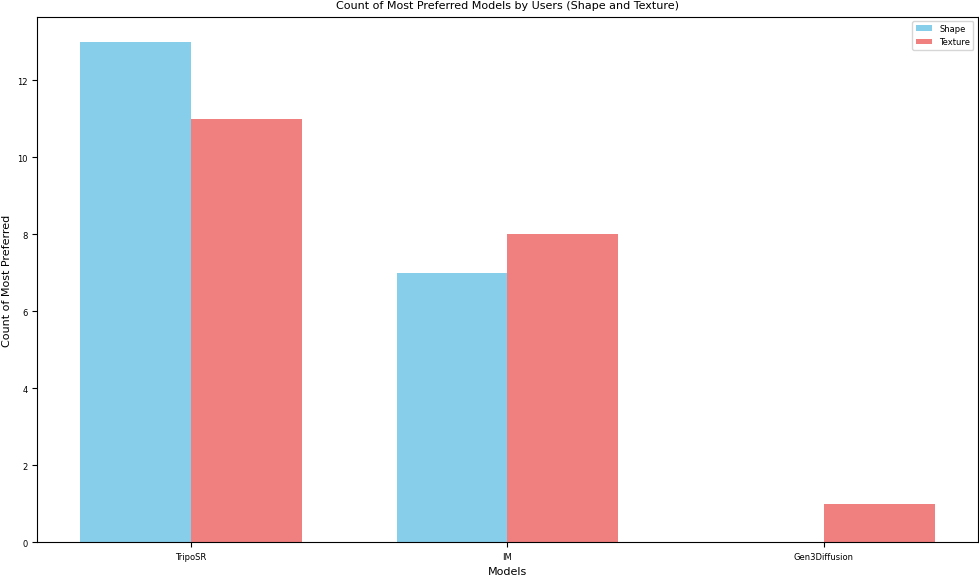

In [23]:
# Filter for each part
shape_df = user_ranking_df[user_ranking_df['Part'] == 'Shape']
texture_df = user_ranking_df[user_ranking_df['Part'] == 'Texture']

# Count the top model occurrences per part
shape_counts = shape_df['TopModel'].value_counts()
texture_counts = texture_df['TopModel'].value_counts()

# Compute the union of models from both parts
union_index = shape_counts.index.union(texture_counts.index)

# Reindex both series to include all models (filling missing counts with 0)
shape_counts = shape_counts.reindex(union_index, fill_value=0)
texture_counts = texture_counts.reindex(union_index, fill_value=0)

# Now sort the union based on the shape counts in descending order.
models_ordered = shape_counts.sort_values(ascending=False).index.tolist()

# Set up x-axis positions and bar width for a grouped bar chart.
x = np.arange(len(models_ordered))
width = 0.35

plt.figure(figsize=(10, 6))
plt.bar(x - width/2, shape_counts.loc[models_ordered].values, width, label='Shape', color='skyblue')
plt.bar(x + width/2, texture_counts.loc[models_ordered].values, width, label='Texture', color='lightcoral')

plt.xlabel("Models")
plt.ylabel("Count of Most Preferred")
plt.title("Count of Most Preferred Models by Users (Shape and Texture)")
plt.xticks(x, models_ordered)
plt.legend()
plt.tight_layout()
plt.show()

